# **Jellyfish Classification with Transfer Learning**
## By Sebastian Mora -  A01746423
### 11-10-23



In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction

This project involves fine-tuning a computer vision model to classify six types of jellyfish. Fine-tuning adapts a pre-trained model to recognize the unique features of each jellyfish species. By leveraging existing knowledge from a broad dataset, the model is tailored to this specific classification task.

The significance of this project lies in its applications for marine biology, environmental monitoring, and conservation. An accurately fine-tuned model can automate jellyfish identification, aiding researchers in population tracking and understanding their ecological impact. This approach contributes to efficient marine ecosystem management and conservation efforts.

## Dataset Description, Import and Normalization

The jellyfish dataset encompasses six distinct classes: 'Moon_jellyfish,' 'barrel_jellyfish,' 'blue_jellyfish,' 'compass_jellyfish,' 'lions_mane_jellyfish,' and 'mauve_stinger_jellyfish.' Each class represents a unique species, capturing the diverse visual characteristics of these jellyfish. This dataset serves as the foundation for training a computer vision model, enabling it to differentiate and classify these specific jellyfish species accurately.

Since we are trying to fine tune de Xception model, we need to normalize the iamges between [-1,1].

In [8]:
from keras.preprocessing import image_dataset_from_directory

# Change this depending on where you are running this script and where you have the dataset
data_dir = "/content/drive/MyDrive/jellyfish_dataset"


# Load train dataset
train_dataset = image_dataset_from_directory(
    data_dir + "/train",
    image_size=(299,299),
    batch_size=64,
)

# Load validation dataset
valid_dataset = image_dataset_from_directory(
    data_dir + "/valid",
    image_size=(299,299),
    batch_size=64,
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    data_dir + "/test",
    image_size=(299,299),
    batch_size=64,
)

# Normalizing pixels tp [-1, 1]
def normalize_img(img, label):
    return (tf.cast(img, tf.float32) / 127.5) - 1, label

class_names = train_dataset.class_names
print("Class names : ",class_names)

train_dataset = train_dataset.map(normalize_img)
valid_dataset = valid_dataset.map(normalize_img)
test_dataset = test_dataset.map(normalize_img)

Found 900 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Class names :  ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


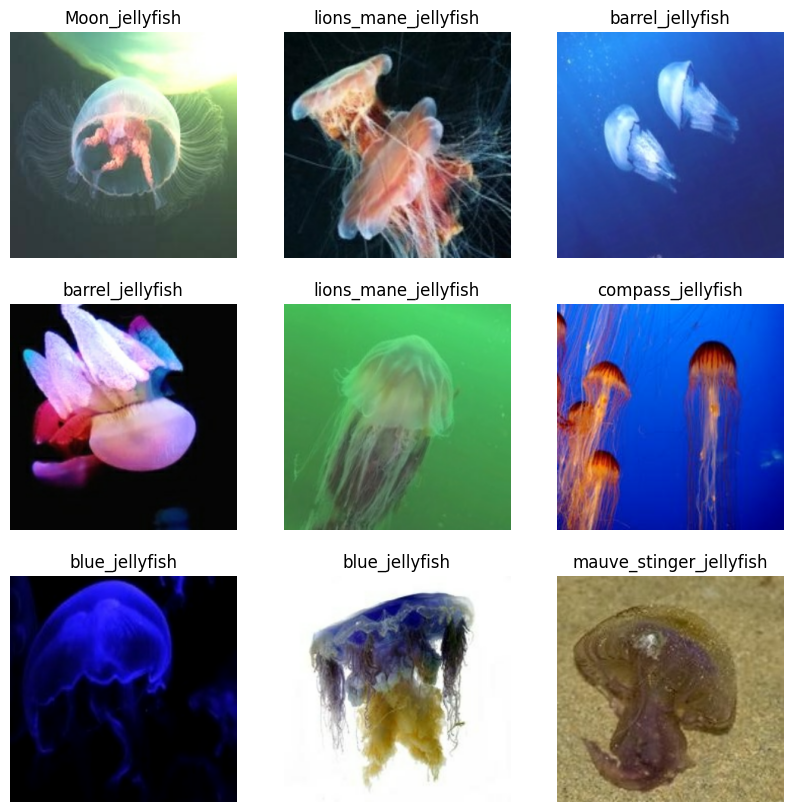

In [9]:
images, labels = next(iter(train_dataset))

# Function for displaying images
def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = (images[i].numpy() + 1.0) * 127.5
        plt.imshow(img.astype("uint8"))

        plt.title(class_names[labels[i]])
        plt.axis("off")

plot_images(images, labels)

## Model Architecture Description

Xception is a model created in 2017, it most relevant feature is the "extreme" use of inception like layers. At first, we can see that it has 87 MB of trainable parameters, but we are going to change the output layer of the model to a softmax(6) output layer, then we freeze all the layers of the original Xception model, to then un-freeze the las 22 layers of the model, leaving the final model with 79 MB of params, of which only 28 MB are trainable.

In [20]:
xception = tf.keras.applications.Xception()
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [21]:
x = xception.layers[-2].output
x = keras.layers.Reshape(target_shape=(2048,))(x)
output = keras.layers.Dense(units=6, activation='softmax')(x)
model = keras.Model(inputs=xception.input, outputs=output)

for layer in model.layers[:-22]:
    layer.trainable = False

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

## Testing the first attempt of training the model
- Adam Optimzer
- Learning Rate : 0.001
- Epochs 5

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_dataset,
            steps_per_epoch=len(train_dataset),
            validation_data=valid_dataset,
            validation_steps=len(valid_dataset),
            epochs=5,
)

Epoch 1/5
15/15 [==============================] - 577s 38s/step - loss: 0.5805 - accuracy: 0.7944 - val_loss: 0.8740 - val_accuracy: 0.7179
Epoch 2/5
15/15 [==============================] - 536s 35s/step - loss: 0.0371 - accuracy: 0.9933 - val_loss: 2.2344 - val_accuracy: 0.6154
Epoch 3/5
15/15 [==============================] - 519s 34s/step - loss: 0.0188 - accuracy: 0.9978 - val_loss: 2.7066 - val_accuracy: 0.6410
Epoch 4/5
15/15 [==============================] - 524s 35s/step - loss: 0.0086 - accuracy: 0.9989 - val_loss: 2.1765 - val_accuracy: 0.6667
Epoch 5/5
15/15 [==============================] - 529s 35s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.9097 - val_accuracy: 0.6923


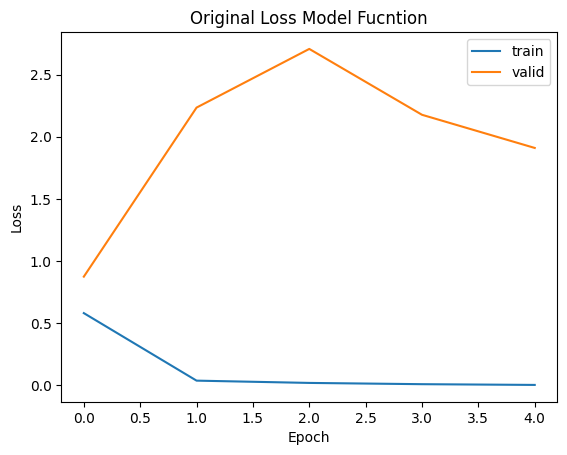

In [15]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Original Loss Model Fucntion')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.show()

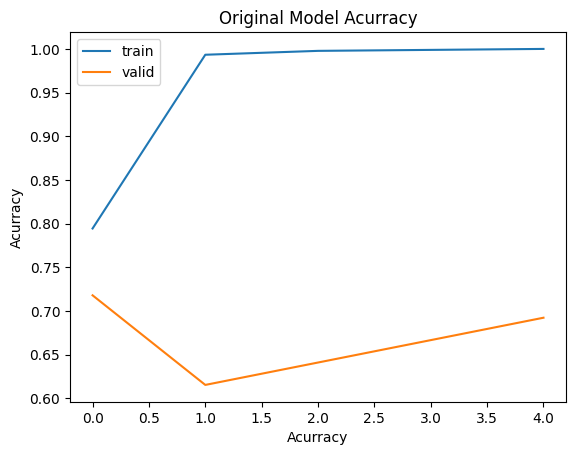

In [14]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Original Model Acurracy')
plt.ylabel('Acurracy')
plt.xlabel('Acurracy')
plt.legend(['train', 'valid'])
plt.show()

40/40 [==============================] - 15s 328ms/step


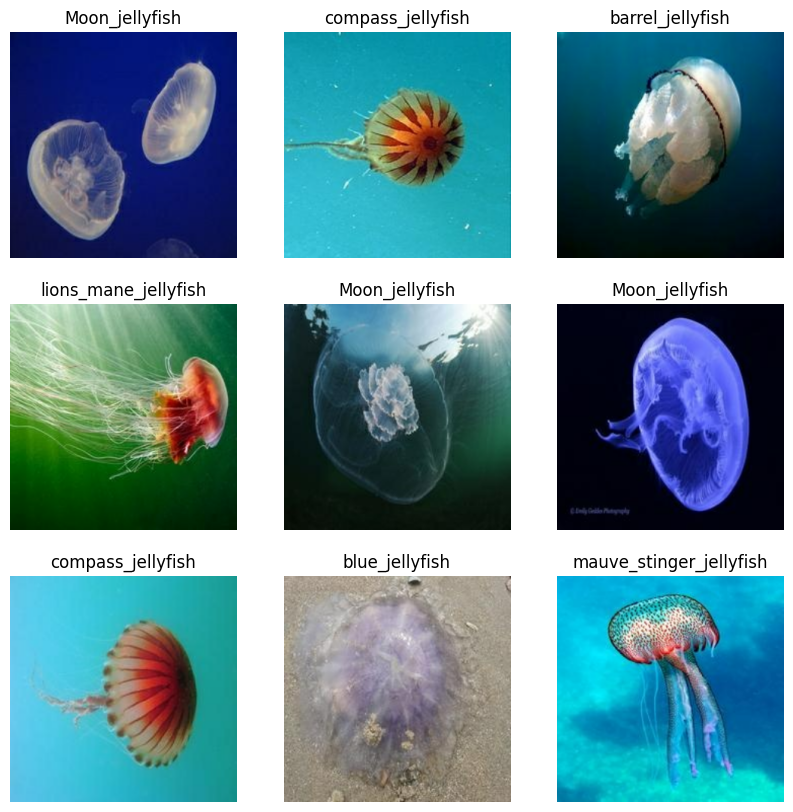

In [16]:
real_labels = []
for images, labels in test_dataset:
    real_labels.extend(labels.numpy())
real_labels = np.array(real_labels)

images, labels = next(iter(test_dataset))

predictions = model.predict(x=images, steps=len(images), verbose=1)

pred_labels = np.argmax(predictions, axis=1)
plot_images(images, pred_labels)

Confusion matrix, without normalization
[[6 0 0 0 0 0]
 [0 5 0 0 0 0]
 [1 0 5 0 0 1]
 [0 0 0 6 1 0]
 [0 0 0 0 8 0]
 [0 0 0 1 0 6]]


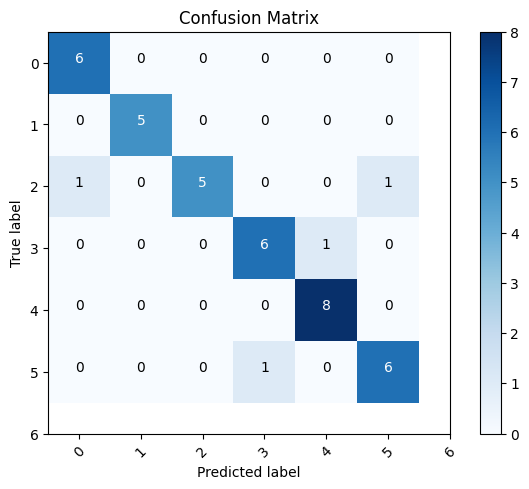

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true=labels, y_pred=pred_labels)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['0','1','2','3','4','5', '6']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Initial Results Observations

We can see a strange form in the grphics generated from the training of the original model. Also, there is a overfit when training in the train dataset. The model ended having a train acurracy of 1 and a valid accuraccy of 0.69, we can see this reflected on the conffusion matrix displayed before.

## Attempting to Improve the Model

We are going to modify some parameters to help the model learn better and prevent overfitting.

- Adam Optimzer
- Learning Rate : 0.0001
- Epochs 10
- Early stopping on accurracy

In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(x=train_dataset,
            steps_per_epoch=len(train_dataset),
            validation_data=valid_dataset,
            validation_steps=len(valid_dataset),
            epochs=12,
          callbacks=[early_stopping]
)

Epoch 1/12
15/15 [==============================] - 567s 37s/step - loss: 1.7503 - accuracy: 0.2433 - val_loss: 1.7860 - val_accuracy: 0.2051
Epoch 2/12
15/15 [==============================] - 521s 35s/step - loss: 1.6185 - accuracy: 0.3744 - val_loss: 1.7191 - val_accuracy: 0.4103
Epoch 3/12
15/15 [==============================] - 524s 35s/step - loss: 1.5042 - accuracy: 0.5422 - val_loss: 1.6505 - val_accuracy: 0.5385
Epoch 4/12
15/15 [==============================] - 529s 35s/step - loss: 1.4013 - accuracy: 0.6556 - val_loss: 1.5832 - val_accuracy: 0.5641
Epoch 5/12
15/15 [==============================] - 513s 34s/step - loss: 1.2965 - accuracy: 0.7389 - val_loss: 1.5164 - val_accuracy: 0.6410
Epoch 6/12
15/15 [==============================] - 529s 35s/step - loss: 1.2008 - accuracy: 0.7889 - val_loss: 1.4501 - val_accuracy: 0.6410
Epoch 7/12
15/15 [==============================] - 528s 35s/step - loss: 1.1144 - accuracy: 0.8244 - val_loss: 1.3868 - val_accuracy: 0.6410
Epoch 

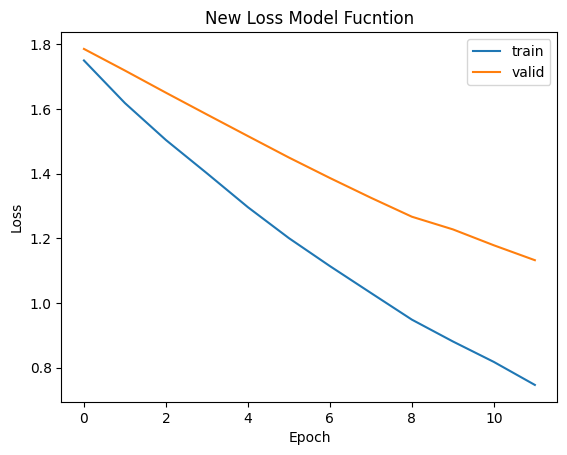

In [23]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('New Loss Model Fucntion')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.show()

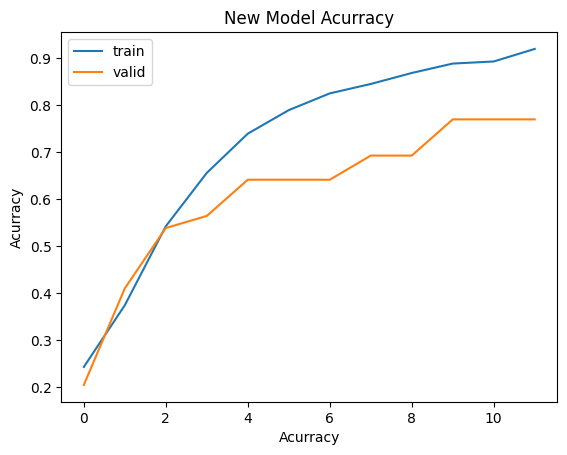

In [24]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('New Model Acurracy')
plt.ylabel('Acurracy')
plt.xlabel('Acurracy')
plt.legend(['train', 'valid'])
plt.show()

40/40 [==============================] - 16s 381ms/step


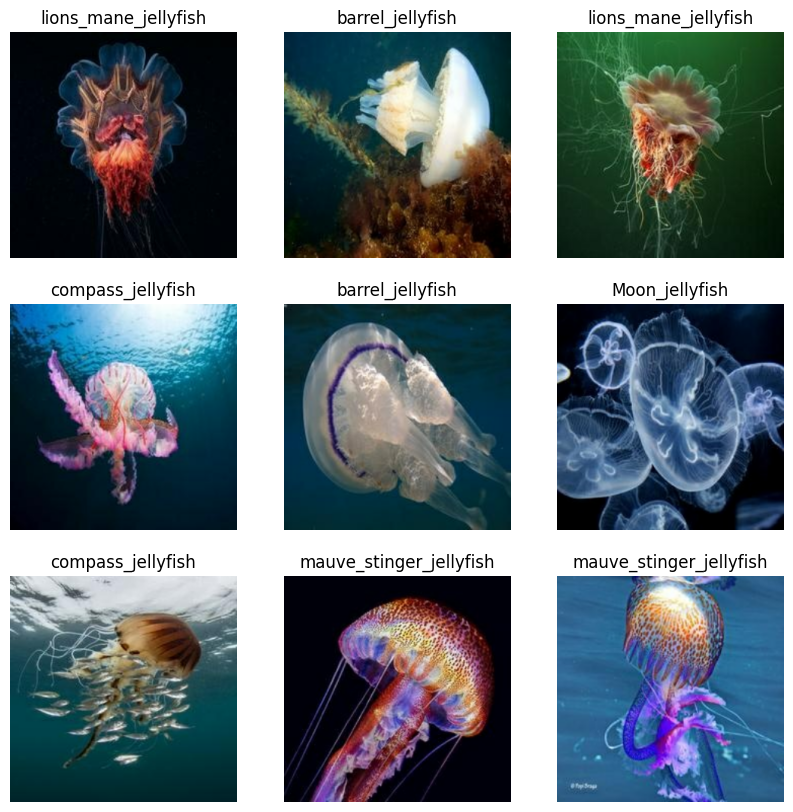

In [25]:
real_labels = []
for images, labels in test_dataset:
    real_labels.extend(labels.numpy())
real_labels = np.array(real_labels)

images, labels = next(iter(test_dataset))

predictions = model.predict(x=images, steps=len(images), verbose=1)

pred_labels = np.argmax(predictions, axis=1)
plot_images(images, pred_labels)

Confusion matrix, without normalization
[[6 0 0 0 0 0]
 [0 5 0 0 0 0]
 [2 0 2 0 2 1]
 [0 0 0 7 0 0]
 [1 0 0 0 7 0]
 [0 0 0 1 0 6]]


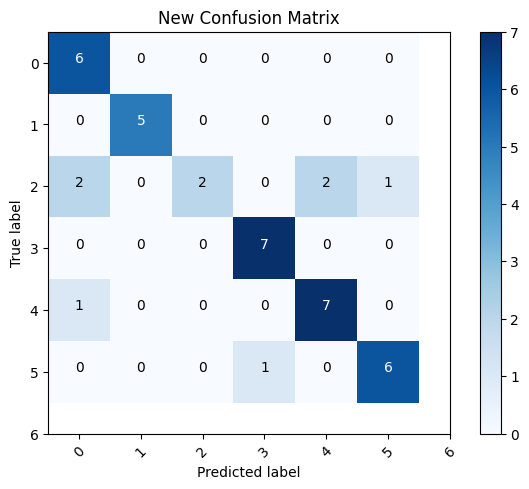

In [26]:
cm = confusion_matrix(y_true=labels, y_pred=pred_labels)
cm_plot_labels = ['0','1','2','3','4','5', '6']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='New Confusion Matrix')

## First Conclusions

We can tell with the new graphs generated by the model with new parameters, that the model its still dosent learning as well as we want, even when the validation accurracy is higher than the first one, we can se in the confusion matrix that the model is generating more wrong predictions than before. I have concluded that the ammount of data im training my model with its a little bit low, beocuse we only have 110 phots per class, it would be ideal to implement a method of data augmentation to help the model to not overfit